Artistic Style Transfer with TensorFlow Lite
# https://www.tensorflow.org/lite/examples/style_transfer/overview?authuser=3

In [1]:
import tensorflow as tf
print(tf.__version__)

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

import PIL

2.9.2


In [2]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

284398/284398 [==============================] - 0s 0us/step


In [30]:
import pandas as pd
import io
from google.colab import files
content_path = files.upload()
print(f"content_path->{content_path}")
# style_path = files.upload()
# print(f"style_path->{style_path}")


Saving Sketch 1-page-001.jpg to Sketch 1-page-001.jpg
content_path->{'Sketch 1-page-001.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x96\x00\x96\x00\x00\xff\xe1\x10\xeaExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x06\x00\x0b\x00\x02\x00\x00\x00&\x00\x00\x08b\x01\x12\x00\x03\x00\x00\x00\x01\x00\x08\x00\x00\x011\x00\x02\x00\x00\x00&\x00\x00\x08\x88\x012\x00\x02\x00\x00\x00\x14\x00\x00\x08\xae\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08\xc2\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00V\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [31]:
!ls
!pwd
style_path = "/content/style13.jpg"
# content_path = "/content/PXL_20221223_034307654.jpg"
content_path = "/content/Sketch 1-page-001.jpg"

 PXL_20221223_034307654.jpg   style13.jpg		    stylized_photo1.png
 sample_data		      stylized_image1.png
'Sketch 1-page-001.jpg'       stylized_image_blended1.png
/content


In [32]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img


In [33]:
# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image


In [34]:
# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


In [35]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


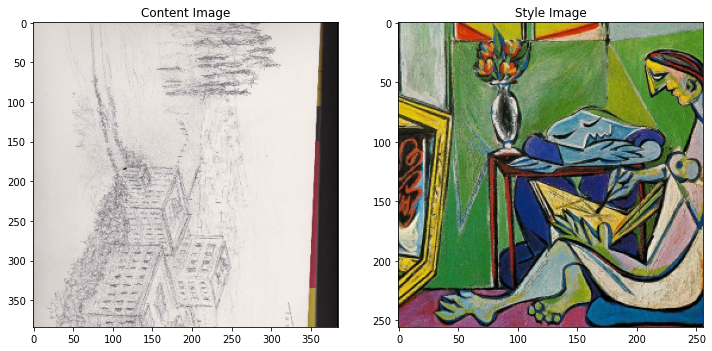

In [36]:
plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [16]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck


In [37]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)


Style Bottleneck Shape: (1, 1, 1, 100)


In [18]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image


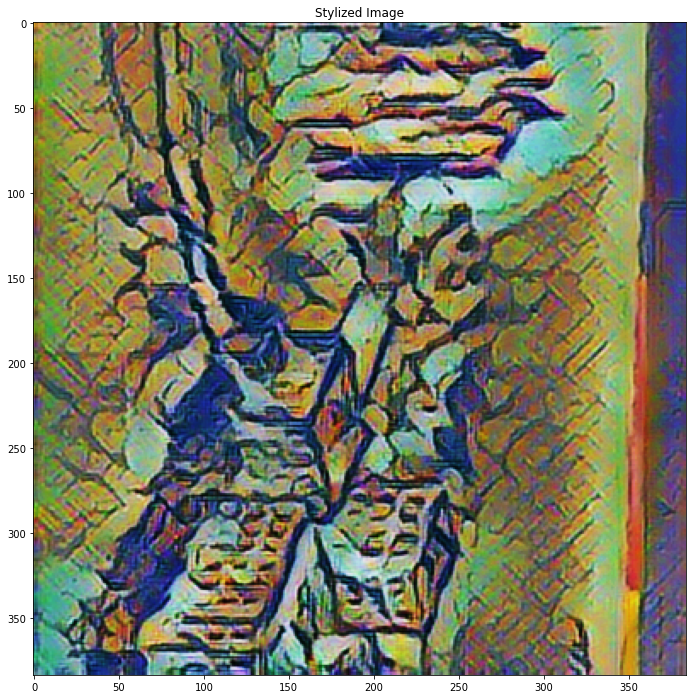

In [38]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

In [20]:
def export_image(tf_img):
    tf_img = tf_img*255
    tf_img = np.array(tf_img, dtype=np.uint8)
    if np.ndim(tf_img)>3:
        assert tf_img.shape[0] == 1
        img = tf_img[0]
    return PIL.Image.fromarray(img)

In [39]:
# export_image(stylized_image).save("stylized_image1.png")
export_image(stylized_image).save("stylized_image2.png")

In [25]:
!ls
!ls sample_data


PXL_20221223_034307654.jpg  style13.jpg		 stylized_photo1.png
sample_data		    stylized_image1.png
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [40]:
# stylized_file = "/content/stylized_image1.png"
stylized_file = "/content/stylized_image2.png"
files.download(stylized_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256))

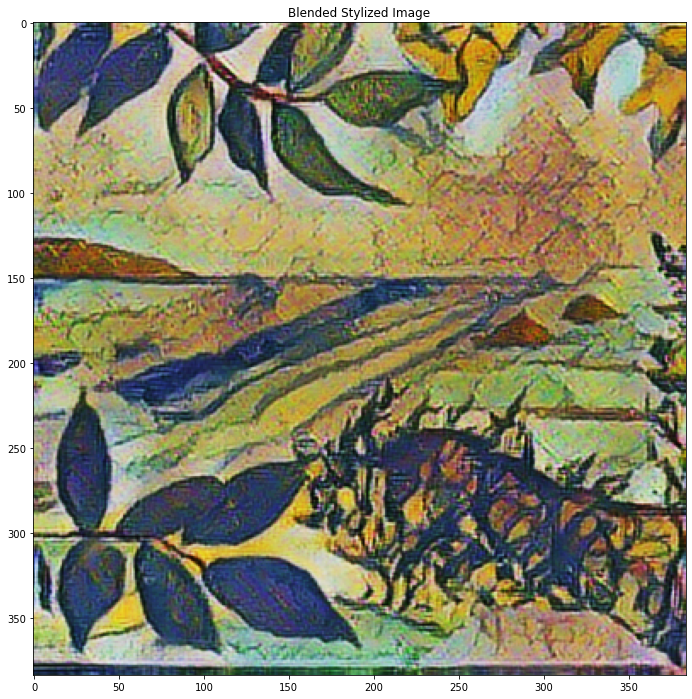

In [28]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

In [29]:
export_image(stylized_image).save("stylized_image_blended1.png")
stylized_image_blended = "/content/stylized_image_blended1.png"
files.download(stylized_image_blended)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>